## Purpose

To compute the ML performance of the proposed method in near real-time.

In [1]:
import os 
import sys
import numpy as np
from collections import defaultdict
import CAN_objects.aid_message
import matplotlib.pyplot as plt

actt_path = os.path.join(os.path.join(os.path.expanduser("~"), "Projects", "CAN", "actt"))
os.chdir(actt_path)
sys.path.insert(0, "src") # add src folder to path so that files from this folder can be imported

from generalFunctions import unpickle
import subprocess

import importlib
importlib.reload(CAN_objects.aid_message)
from init_cancapture_from_canlog import init_cancap
import json
import seaborn as sns
import pandas as pd

from CAN_objects.capture import MappedCapture, MatchedCapture
import math
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, linkage, fcluster

from pprint import pprint
from sklearn.metrics.cluster import normalized_mutual_info_score

from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

import glob
from tqdm import tqdm
import itertools
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, spearmanr
from sklearn.preprocessing import normalize, scale, MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings("ignore")

## Enable the Use of Functions From the Detect Repo

In [2]:
# sys.path.insert(0, "/home/cades/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
sys.path.insert(0, "/home/cloud/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
import signal_based_preprocess_functions
print(os.getcwd())

/home/cloud/Projects/CAN/actt


## Functions

In [67]:
def from_capture_to_time_series(cap, ground_truth_dbc_path):
    
    signal_multivar_ts, timepts, aid_signal_tups = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap, ground_truth_dbc_path)

    return signal_multivar_ts, timepts, aid_signal_tups


def from_captures_to_time_series(cap_1, cap_2, ground_truth_dbc_path):
        
    signal_multivar_ts_1, timepts_1, aid_signal_tups_1 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_1, ground_truth_dbc_path)
    signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_2, ground_truth_dbc_path)

    return signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2


def remove_constant_signals(signal_multivar_ts):
    return signal_multivar_ts[:, ~np.all(signal_multivar_ts[1:] == signal_multivar_ts[:-1], axis=0)]


def partition_time_series(signal_multivar_ts, window_length, offset):
    
    n = signal_multivar_ts.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(signal_multivar_ts[i: i + window_length,:])
        i = i + offset
        
    if i != n:
        partition.append(signal_multivar_ts[i:n,:])
        
    return partition
    
    
def process_multivariate_signals(df, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    # df = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts[:,index] for index, tup in enumerate(aid_signal_tups)})
    # display(df.shape)

    # Remove columns with constant values
    df = df.loc[:, (df != df.iloc[0]).any()] 
    # display(df.shape)
    
    # Stadarization
    # df_standardized = (df-df.mean())/df.std()
    # display(df_standardized)

    # normalization
    df_standardized = (df-df.min())/(df.max()-df.min())
    
    # Partition of data frames
    n = df_standardized.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(df_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition.append(df_standardized.iloc[i:n, :])
        
    return partition


def process_multiple_multivariate_signals(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    # display(df)
    print(df_1.shape)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_1_standardized = (df_1-df_1.mean())/df_1.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_1_standardized.shape[0]
    i = 0
    partition_1 = []
    
    while (i + window_length) < n:
        partition_1.append(df_1_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_1.append(df_1_standardized.iloc[i:n, :])
        
        
    # Second dataframe
    # Convert matrix of time series into a dataframe
    df_2 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_2[:,index] for index, tup in enumerate(aid_signal_tups_2)})
    # display(df)
    print(df_2.shape)

    # Remove columns with constant values
    df_2 = df_2.loc[:, (df_2 != df_2.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_2_standardized = (df_2-df_2.mean())/df_2.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_2_standardized.shape[0]
    i = 0
    partition_2 = []
    
    while (i + window_length) < n:
        partition_2.append(df_2_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_2.append(df_2_standardized.iloc[i:n, :])
        
    return partition_1, partition_2


def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
  
    if type(df) == np.ndarray: # numpy array option
        mask = np.triu_indices(df.shape[0], k=1)
        print("df: ", df) 
        print("mask: ", mask)
        print("filtered:", df[mask])
        return df[mask]

    elif type(df) == pd.DataFrame: # pandas data frame option
        mask = np.triu_indices(df.shape[0], k=1)
        df = df.to_numpy()
        return df[mask]



def randomized_test_permutations(m1, m2):
    """Nonparametric permutation testing Monte Carlo"""
    np.random.seed(0)
    rhos = []
    n_iter = 100
    true_rho, _ = spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for iter in range(n_iter):
        np.random.shuffle(m_ids) # shuffle list 
        r, _ = spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
        rhos.append(r)
    perm_p = ((np.sum(np.abs(true_rho) <= np.abs(rhos)))+1)/(n_iter+1) # two-tailed test

    return perm_p


def compute_correlation_matrices(partition):
    
    corr_matrices = []

    for df in partition:

        # Remove columns with constant values
        df = df.loc[:, (df != df.iloc[0]).any()] 

        # Compute correlation matrix
        # corr_matrices.append(df.corr(method="pearson"))
        print("df size: ", df.shape)
        corr_matrices.append(np.corrcoef(df.to_numpy(), rowvar=False))
        
    return corr_matrices


def compute_similarity_from_correlation_matrices(corr_matrices):
    
    similarities = []
    
    for i in range(len(corr_matrices)-1):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices[i].columns.values
        signal_names_2 = corr_matrices[i+1].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices[i+1].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
    return similarities


def compute_similarity_from_multiple_correlation_matrices(corr_matrices_1, corr_matrices_2):
    
    similarities = []
    
    if len(corr_matrices_1) <= len(corr_matrices_2):
        corr_matrices_reference = corr_matrices_1
    else:
        corr_matrices_reference = corr_matrices_2
        
    print(len(corr_matrices_reference))
            
    for i in range(len(corr_matrices_reference)):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices_1[i].columns.values
        signal_names_2 = corr_matrices_2[i].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices_1[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices_2[i].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        # similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
        correlation = spearmanr(upper(df_1), upper(df_2))[0]
        p_value = spearmanr(upper(df_1), upper(df_2))[1]
        
        if p_value > 0.05:
            similarities.append((i, correlation, p_value))
        else:
            similarities.append(i)
            
        
    return similarities


def create_time_intervals(time_steps, window, offset):
    
    # Partition of data frames
    i = 0
    intervals = []
    total_length = len(time_steps)
    
    while (i + window) < total_length:
        intervals.append((time_steps[i], time_steps[i + window]))
        i = i + offset
        
    if i != total_length:
        intervals.append((time_steps[i] , time_steps[total_length-1]))
        
    return intervals


    # # Partition of data frames
    # n = df_standardized.shape[0]
    # i = 0
    # partition = []
    
    # while (i + window_length) < n:
    #     partition.append(df_standardized.iloc[i:i + window_length, :])
    #     i = i + offset
        
    # if i != n:
    #     partition.append(df_standardized.iloc[i:n, :])
        
    # return partition
    

    # intervals = []
    # # offset = 0.1*offset
    
    # for i in np.arange(0, total_length - window + 1, offset, dtype=float):
    #     intervals.append((i, i + window))

    # if i + window < total_length:
    #     intervals.append((i + offset, total_length))

    # return intervals  


def process_CAN_file(file_name):

    # read data frame
    df = pd.read_csv(file_name, engine="c")

    # remove unwanted column
    df = df.drop("Unnamed: 0", axis=1)

    # reorganize columns
    df.insert(0, "Label", df.pop("Label"))
    df.insert(0, "Time", df.pop("Time"))
    df.insert(0, "ID", df.pop("ID"))

    # Forward filling process
    df = df.ffill().copy() # Fill up the missing values with the most recent values
    df = df.bfill().dropna() # Fill up the remaining missing values in the first few rows
    # display(df)

    return df
    

## File Names

In [4]:
testing_captures = ["correlated_masquerade_1_030804_082640", "correlated_masquerade_2_031128_011320", "correlated_masquerade_3_040322_190000", 
                    "road_attack_max_speedometer_attack_1_masquerade_060215_054000", "road_attack_max_speedometer_attack_2_masquerade_060611_002640", 
                    "road_attack_max_speedometer_attack_3_masquerade_061004_181320", "road_attack_max_engine_coolant_temp_attack_masquerade_041109_063320",
                    "road_attack_reverse_light_on_attack_1_masquerade_091205_030000", "road_attack_reverse_light_on_attack_2_masquerade_100330_214640", 
                    "road_attack_reverse_light_on_attack_3_masquerade_100724_153320", "road_attack_reverse_light_off_attack_1_masquerade_080110_162000", 
                    "road_attack_reverse_light_off_attack_2_masquerade_080505_110640", "road_attack_reverse_light_off_attack_3_masquerade_080829_045320"]

print(len(testing_captures), testing_captures) 

13 ['correlated_masquerade_1_030804_082640', 'correlated_masquerade_2_031128_011320', 'correlated_masquerade_3_040322_190000', 'road_attack_max_speedometer_attack_1_masquerade_060215_054000', 'road_attack_max_speedometer_attack_2_masquerade_060611_002640', 'road_attack_max_speedometer_attack_3_masquerade_061004_181320', 'road_attack_max_engine_coolant_temp_attack_masquerade_041109_063320', 'road_attack_reverse_light_on_attack_1_masquerade_091205_030000', 'road_attack_reverse_light_on_attack_2_masquerade_100330_214640', 'road_attack_reverse_light_on_attack_3_masquerade_100724_153320', 'road_attack_reverse_light_off_attack_1_masquerade_080110_162000', 'road_attack_reverse_light_off_attack_2_masquerade_080505_110640', 'road_attack_reverse_light_off_attack_3_masquerade_080829_045320']


## Obtain Metadata

In [5]:
# with open("/home/cades/Projects/CAN/actt/data/capture_metadata.json") as f:
with open("/home/cloud/Projects/CAN/actt/data/capture_metadata.json") as f:
    attack_metadata = json.load(f)
    
# pprint(testing_captures)
# pprint(attack_metadata)

attack_metadata_keys = ["correlated_signal_attack_1_masquerade", "correlated_signal_attack_2_masquerade", "correlated_signal_attack_3_masquerade", 
                        "max_speedometer_attack_1_masquerade", "max_speedometer_attack_2_masquerade", "max_speedometer_attack_3_masquerade",
                        "max_engine_coolant_temp_attack_masquerade", "reverse_light_on_attack_1_masquerade", "reverse_light_on_attack_2_masquerade",
                        "reverse_light_on_attack_3_masquerade", "reverse_light_off_attack_1_masquerade", "reverse_light_off_attack_2_masquerade",
                        "reverse_light_off_attack_3_masquerade"]

print(len(attack_metadata_keys))

13


In [6]:
print(attack_metadata_keys[0])
attack_metadata["correlated_signal_attack_1_masquerade"]

correlated_signal_attack_1_masquerade


{'description': 'start from driving; accelerate; start injecting; car rolls to stop; stop injecting; accelerate',
 'elapsed_sec': 33.101852,
 'injection_data_str': '595945450000FFFF',
 'injection_id': '0x6e0',
 'injection_interval': [9.191851, 30.050109],
 'modified': True,
 'on_dyno': True}

## Experiments on a Single Capture File (Distribution-Based)

In [7]:
df_benign = pd.read_csv("/home/cloud/Projects/CAN/actt/data/ROAD-data-time-series/generated/ambient/ambient_dyno_drive_extended_long_generated.csv", engine="c") # Reading data
display(df_benign)

,Unnamed: 0,Signal_1_of_ID_263,Signal_2_of_ID_263,Signal_3_of_ID_263,Signal_4_of_ID_263,Signal_5_of_ID_263,Signal_6_of_ID_263,Signal_7_of_ID_263,Signal_8_of_ID_263,Signal_9_of_ID_263,...,Signal_2_of_ID_705,Signal_3_of_ID_705,Signal_4_of_ID_705,Signal_5_of_ID_705,Signal_6_of_ID_705,Signal_7_of_ID_705,Signal_8_of_ID_705,ID,Label,Time
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.0,0.0,0.000000
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1621.0,0.0,0.001018
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0,0.0,0.001019
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,813.0,0.0,0.010104
4,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.0,0.0,0.020093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335044,1277001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-100.0,-1.0,-110.0,1.0,1.0,143.0,111.0,651.0,0.0,657.872243
1335045,1277234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-96.0,-1.0,-112.0,1.0,1.0,131.0,121.0,14.0,0.0,657.872244
1335046,1277464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-97.0,-1.0,-113.0,1.0,1.0,122.0,132.0,167.0,0.0,657.872245
1335047,1277646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-97.0,-1.0,-110.0,1.0,1.0,109.0,142.0,458.0,0.0,657.873274


In [8]:
# df_benign.insert(0, "Label", df_benign.pop("Label"))
# df_benign.insert(0, "Time", df_benign.pop("Time"))
# df_benign.insert(0, "ID", df_benign.pop("ID"))

df_benign = df_benign.drop(["Unnamed: 0", "Label", "Time", "ID"], axis=1)

display(df_benign)

,Signal_1_of_ID_263,Signal_2_of_ID_263,Signal_3_of_ID_263,Signal_4_of_ID_263,Signal_5_of_ID_263,Signal_6_of_ID_263,Signal_7_of_ID_263,Signal_8_of_ID_263,Signal_9_of_ID_263,Signal_1_of_ID_1621,...,Signal_4_of_ID_961,Signal_5_of_ID_961,Signal_1_of_ID_705,Signal_2_of_ID_705,Signal_3_of_ID_705,Signal_4_of_ID_705,Signal_5_of_ID_705,Signal_6_of_ID_705,Signal_7_of_ID_705,Signal_8_of_ID_705
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,-100.0,-1.0,-110.0,1.0,1.0,143.0,111.0
1335045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,-96.0,-1.0,-112.0,1.0,1.0,131.0,121.0
1335046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,-97.0,-1.0,-113.0,1.0,1.0,122.0,132.0
1335047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,-97.0,-1.0,-110.0,1.0,1.0,109.0,142.0


In [9]:
# df_benign.sort_values(by="Time", ascending=True, inplace=True)
# display(df_benign)

## Forward Filling Mechanism

In [10]:
df_benign = df_benign.ffill().copy() # Fill up the missing values with the most recent values
df_benign = df_benign.bfill().dropna() # Fill up the remaining missing values in the first few rows
display(df_benign)

,Signal_1_of_ID_263,Signal_2_of_ID_263,Signal_3_of_ID_263,Signal_4_of_ID_263,Signal_5_of_ID_263,Signal_6_of_ID_263,Signal_7_of_ID_263,Signal_8_of_ID_263,Signal_9_of_ID_263,Signal_1_of_ID_1621,...,Signal_4_of_ID_961,Signal_5_of_ID_961,Signal_1_of_ID_705,Signal_2_of_ID_705,Signal_3_of_ID_705,Signal_4_of_ID_705,Signal_5_of_ID_705,Signal_6_of_ID_705,Signal_7_of_ID_705,Signal_8_of_ID_705
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,250.0,152.0,0.0,-100.0,-1.0,-110.0,1.0,1.0,143.0,111.0
1335045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,250.0,152.0,0.0,-96.0,-1.0,-112.0,1.0,1.0,131.0,121.0
1335046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,250.0,152.0,0.0,-97.0,-1.0,-113.0,1.0,1.0,122.0,132.0
1335047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,250.0,152.0,0.0,-97.0,-1.0,-110.0,1.0,1.0,109.0,142.0


## Partition Time Series Benign

In [11]:
window = df_benign.shape[0]
offset = window
partition_training = process_multivariate_signals(df_benign, window, offset)

In [12]:
print(len(partition_training))
partition_training[0]

1


,Signal_1_of_ID_263,Signal_2_of_ID_263,Signal_3_of_ID_263,Signal_4_of_ID_263,Signal_5_of_ID_263,Signal_7_of_ID_263,Signal_8_of_ID_263,Signal_9_of_ID_263,Signal_1_of_ID_1621,Signal_6_of_ID_1621,...,Signal_4_of_ID_961,Signal_5_of_ID_961,Signal_1_of_ID_705,Signal_2_of_ID_705,Signal_3_of_ID_705,Signal_4_of_ID_705,Signal_5_of_ID_705,Signal_6_of_ID_705,Signal_7_of_ID_705,Signal_8_of_ID_705
0,0.0,0.468864,0.0,0.0,0.0,0.0,0.0,0.0,0.576271,0.0,...,0.000000,0.000000,1.0,1.000000,1.0,1.000000,0.0,0.0,0.000000,0.000000
1,0.0,0.468864,0.0,0.0,0.0,0.0,0.0,0.0,0.576271,0.0,...,0.000000,0.000000,1.0,1.000000,1.0,1.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.468864,0.0,0.0,0.0,0.0,0.0,0.0,0.576271,0.0,...,0.000000,0.000000,1.0,1.000000,1.0,1.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.468864,0.0,0.0,0.0,0.0,0.0,0.0,0.576271,0.0,...,0.000000,0.000000,1.0,1.000000,1.0,1.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.468864,0.0,0.0,0.0,0.0,0.0,0.0,0.576271,0.0,...,0.000000,0.000000,1.0,1.000000,1.0,1.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335044,0.0,0.468864,0.0,0.0,0.0,0.0,0.0,0.0,0.525424,1.0,...,0.980392,0.596078,0.0,0.159664,0.0,0.303797,1.0,1.0,0.560784,0.435294
1335045,0.0,0.468864,0.0,0.0,0.0,0.0,0.0,0.0,0.525424,1.0,...,0.980392,0.596078,0.0,0.193277,0.0,0.291139,1.0,1.0,0.513725,0.474510
1335046,0.0,0.468864,0.0,0.0,0.0,0.0,0.0,0.0,0.525424,1.0,...,0.980392,0.596078,0.0,0.184874,0.0,0.284810,1.0,1.0,0.478431,0.517647
1335047,0.0,0.468864,0.0,0.0,0.0,0.0,0.0,0.0,0.525424,1.0,...,0.980392,0.596078,0.0,0.184874,0.0,0.303797,1.0,1.0,0.427451,0.556863


## Compute Correlation Matrices

In [13]:
corr_matrices_training = compute_correlation_matrices(partition_training)

In [14]:
len(corr_matrices_training)

1

In [16]:
[corr_matrices_training[i].shape for i in range(len(corr_matrices_training))]

[(462, 462)]

In [17]:
corr_sample_training = np.concatenate([upper(corr_matrices_training[i]) for i in range(len(corr_matrices_training))])
len(corr_sample_training)

106491

In [18]:
corr_sample_training

array([0.59567539, 1.        , 1.        , ..., 0.86307551, 0.86482792,
       0.52467158])

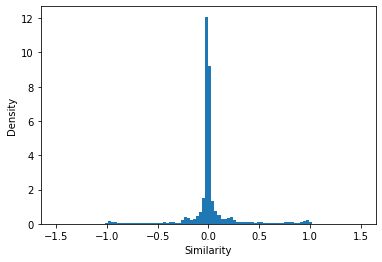

In [22]:
fig, ax = plt.subplots()

ax.hist(corr_sample_training, bins=100, range=(-1.5, 1.5), density=True)

ax.set_xlabel("Similarity")
ax.set_ylabel("Density")

plt.show()

## Partition Time Series Attack

In [23]:
testing_captures

['correlated_masquerade_1_030804_082640',
 'correlated_masquerade_2_031128_011320',
 'correlated_masquerade_3_040322_190000',
 'road_attack_max_speedometer_attack_1_masquerade_060215_054000',
 'road_attack_max_speedometer_attack_2_masquerade_060611_002640',
 'road_attack_max_speedometer_attack_3_masquerade_061004_181320',
 'road_attack_max_engine_coolant_temp_attack_masquerade_041109_063320',
 'road_attack_reverse_light_on_attack_1_masquerade_091205_030000',
 'road_attack_reverse_light_on_attack_2_masquerade_100330_214640',
 'road_attack_reverse_light_on_attack_3_masquerade_100724_153320',
 'road_attack_reverse_light_off_attack_1_masquerade_080110_162000',
 'road_attack_reverse_light_off_attack_2_masquerade_080505_110640',
 'road_attack_reverse_light_off_attack_3_masquerade_080829_045320']

In [24]:
df_attack = process_CAN_file("/home/cloud/Projects/CAN/actt/data/ROAD-data-time-series/generated/attack/correlated_signal_attack_1_masquerade_generated.csv")
display(df_attack)

,ID,Time,Label,Signal_1_of_ID_852,Signal_2_of_ID_852,Signal_3_of_ID_852,Signal_4_of_ID_852,Signal_1_of_ID_1505,Signal_2_of_ID_1505,Signal_3_of_ID_1505,...,Signal_2_of_ID_1621,Signal_3_of_ID_1621,Signal_4_of_ID_1621,Signal_5_of_ID_1621,Signal_6_of_ID_1621,Signal_7_of_ID_1621,Signal_8_of_ID_1621,Signal_9_of_ID_1621,Signal_1_of_ID_1649,Signal_2_of_ID_1649
0,852.0,0.000000,0.0,32808.0,0.0,78.0,9.0,510.0,2.0,3.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
1,1505.0,0.001020,0.0,32808.0,0.0,76.0,11.0,510.0,2.0,3.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,651.0,0.001021,0.0,32808.0,0.0,76.0,11.0,510.0,2.0,3.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
3,167.0,0.001023,0.0,32808.0,0.0,75.0,12.0,510.0,2.0,3.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
4,208.0,0.001024,0.0,32808.0,0.0,75.0,12.0,510.0,2.0,3.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74147,51.0,33.097961,0.0,32791.0,0.0,97.0,7.0,511.0,1.0,3.0,...,-1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
74148,167.0,33.097963,0.0,32791.0,0.0,97.0,7.0,511.0,1.0,3.0,...,-1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
74149,61.0,33.097964,0.0,32791.0,0.0,97.0,7.0,511.0,1.0,3.0,...,-1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
74150,1413.0,33.099802,0.0,32791.0,0.0,97.0,7.0,511.0,1.0,3.0,...,-1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


In [25]:
time_steps = df_attack["Time"].to_numpy()
display(time_steps)

array([0.00000000e+00, 1.01995468e-03, 1.02102757e-03, ...,
       3.30979640e+01, 3.30998020e+01, 3.31018521e+01])

In [26]:
df_attack = df_attack.drop(["Label", "Time", "ID"], axis=1)

display(df_attack)

,Signal_1_of_ID_852,Signal_2_of_ID_852,Signal_3_of_ID_852,Signal_4_of_ID_852,Signal_1_of_ID_1505,Signal_2_of_ID_1505,Signal_3_of_ID_1505,Signal_4_of_ID_1505,Signal_5_of_ID_1505,Signal_6_of_ID_1505,...,Signal_2_of_ID_1621,Signal_3_of_ID_1621,Signal_4_of_ID_1621,Signal_5_of_ID_1621,Signal_6_of_ID_1621,Signal_7_of_ID_1621,Signal_8_of_ID_1621,Signal_9_of_ID_1621,Signal_1_of_ID_1649,Signal_2_of_ID_1649
0,32808.0,0.0,78.0,9.0,510.0,2.0,3.0,1.0,0.0,32846.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
1,32808.0,0.0,76.0,11.0,510.0,2.0,3.0,1.0,0.0,32846.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,32808.0,0.0,76.0,11.0,510.0,2.0,3.0,1.0,0.0,32846.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
3,32808.0,0.0,75.0,12.0,510.0,2.0,3.0,1.0,0.0,32846.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
4,32808.0,0.0,75.0,12.0,510.0,2.0,3.0,1.0,0.0,32846.0,...,-1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74147,32791.0,0.0,97.0,7.0,511.0,1.0,3.0,1.0,0.0,32842.0,...,-1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
74148,32791.0,0.0,97.0,7.0,511.0,1.0,3.0,1.0,0.0,32842.0,...,-1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
74149,32791.0,0.0,97.0,7.0,511.0,1.0,3.0,1.0,0.0,32842.0,...,-1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
74150,32791.0,0.0,97.0,7.0,511.0,1.0,3.0,1.0,0.0,32842.0,...,-1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


In [27]:
window = 500
offset = window
partition_testing = process_multivariate_signals(df_attack, window, offset)

In [28]:
print(len(partition_testing))
partition_testing[0]

149


,Signal_1_of_ID_852,Signal_3_of_ID_852,Signal_4_of_ID_852,Signal_1_of_ID_1505,Signal_2_of_ID_1505,Signal_6_of_ID_1505,Signal_4_of_ID_167,Signal_5_of_ID_167,Signal_6_of_ID_167,Signal_7_of_ID_167,...,Signal_3_of_ID_953,Signal_7_of_ID_778,Signal_1_of_ID_1331,Signal_5_of_ID_1751,Signal_5_of_ID_631,Signal_5_of_ID_930,Signal_1_of_ID_1621,Signal_6_of_ID_1621,Signal_1_of_ID_1649,Signal_2_of_ID_1649
0,0.452632,0.518519,0.571429,0.994444,1.0,0.890411,0.0,0.376543,0.0,0.333333,...,0.0,0.0,0.25,0.0,0.0,0.0,0.559322,0.0,1.0,0.0
1,0.452632,0.500000,0.714286,0.994444,1.0,0.890411,0.0,0.376543,0.0,0.333333,...,0.0,0.0,0.25,0.0,0.0,0.0,0.559322,0.0,1.0,0.0
2,0.452632,0.500000,0.714286,0.994444,1.0,0.890411,0.0,0.376543,0.0,0.333333,...,0.0,0.0,0.25,0.0,0.0,0.0,0.559322,0.0,1.0,0.0
3,0.452632,0.490741,0.785714,0.994444,1.0,0.890411,0.0,0.376543,0.0,0.333333,...,0.0,0.0,0.25,0.0,0.0,0.0,0.559322,0.0,1.0,0.0
4,0.452632,0.490741,0.785714,0.994444,1.0,0.890411,0.0,0.376543,0.0,0.333333,...,0.0,0.0,0.25,0.0,0.0,0.0,0.559322,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.726316,0.296296,0.428571,0.994444,1.0,0.890411,0.0,0.376543,0.0,0.333333,...,0.0,0.0,0.25,0.0,0.0,0.0,0.559322,0.0,1.0,0.0
496,0.726316,0.277778,0.571429,0.994444,1.0,0.890411,0.0,0.376543,0.0,0.333333,...,0.0,0.0,0.25,0.0,0.0,0.0,0.559322,0.0,1.0,0.0
497,0.726316,0.259259,0.714286,0.994444,1.0,0.890411,0.0,0.376543,0.0,0.333333,...,0.0,0.0,0.25,0.0,0.0,0.0,0.559322,0.0,1.0,0.0
498,0.726316,0.259259,0.714286,0.994444,1.0,0.890411,0.0,0.376543,0.0,0.333333,...,0.0,0.0,0.25,0.0,0.0,0.0,0.559322,0.0,1.0,0.0


## Compute Correlation Matrices

In [29]:
corr_matrices_testing = compute_correlation_matrices(partition_testing)
len(corr_matrices_testing)

149

In [36]:
for corr_matrix in corr_matrices_testing:
    print(corr_matrix.shape)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(2, 2)
(5, 5)
(2, 2)
(2, 2)
(2, 2)
(3, 3)
(2, 2)
(2, 2)
()
(0, 0)
(0, 0)
(2, 2)
(3, 3)
(3, 3)
(3, 3)
(4, 4)
(4, 4)
(4, 4)
(6, 6)
(3, 3)
(3, 3)
(3, 3)
(5, 5)
(4, 4)
(9, 9)
(3, 3)
(4, 4)
(3, 3)
(6, 6)
(6, 6)
(6, 6)
(5, 5)
(5, 5)
(3, 3)
(3, 3)
(3, 3)
(2, 2)
(2, 2)
(5, 5)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
()
()
(5, 5)
(4, 4)
(4, 4)
(6, 6)
(3, 3)
(2, 2)
(2, 2)
(3, 3)
()
(2, 2)
(5, 5)
(3, 3)
(3, 3)
(7, 7)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(0, 0)
(0, 0)
(4, 4)
(4, 4)
(4, 4)
(0, 0)
(0, 0)
(0, 0)
(4, 4)
(4, 4)
(0, 0)
()
(0, 0)
(0, 0)
()
(4, 4)
(4, 4)
(4, 4)
(4, 4)
(6, 6)
(6, 6)
(7, 7)
(4, 4)
(0, 0)
(0, 0)
()
()
(5, 5)
(6, 6)
(5, 5)
(3, 3)
(5, 5)
(5, 5)
(3, 3)
(3, 3)
(3, 3)
(6, 6)
(2, 2)
(2, 2)
(2, 2)
(0, 0)
(0, 0)
(3, 3)
(3, 3)
(17, 17)
()
(6, 6)
(5, 5)
(0, 0)
(2, 2)
(2, 2)
(4, 4)
(3, 3)
(3, 3)
(4, 4)
(3, 3)
(5, 5)
(4, 4)
(2, 2)
(0, 0)
(0, 0)
(3, 3)
(3, 3)
(3, 3)
(13, 13)
(10, 10)
(2, 2)
(3, 3)
(6, 6)
(3, 3)
(5, 5)
(5, 5)
(10, 10)
(13, 13)
(17, 17)
(8

In [37]:
# for i in tqdm(range(len(corr_matrices_testing))):
    
#     corr_sample_testing = upper(corr_matrices_testing[i])
    
#     p_value = mannwhitneyu(corr_sample_training, corr_sample_testing)[1]
    
#     if p_value <= 0.05:
        
#         print(i, mannwhitneyu(corr_sample_training, corr_sample_testing))
        
# #         fig, ax = plt.subplots()

# #         ax.hist(corr_sample_training, bins=50, alpha=0.5, density=True, label="Benign")
# #         ax.set_xlabel("Similarity")
# #         ax.set_ylabel("Density")
# #         ax.hist(corr_sample_testing, bins=50, alpha=0.5, density=True, label="Attack")
# #         ax.legend(loc="upper right")

# #         plt.show() 

In [38]:
display(attack_metadata_keys[0])
attack_metadata[attack_metadata_keys[0]]

'correlated_signal_attack_1_masquerade'

{'description': 'start from driving; accelerate; start injecting; car rolls to stop; stop injecting; accelerate',
 'elapsed_sec': 33.101852,
 'injection_data_str': '595945450000FFFF',
 'injection_id': '0x6e0',
 'injection_interval': [9.191851, 30.050109],
 'modified': True,
 'on_dyno': True}

## Experiments Comparing Distributions

## Hypothesis Testing (Single Attack)

In [68]:
window = 500
offset = window

print("Processing: ", attack_metadata_keys[0])
df_attack = process_CAN_file("/home/cloud/Projects/CAN/actt/data/ROAD-data-time-series/generated/attack/correlated_signal_attack_1_masquerade_generated.csv")
time_steps = df_attack["Time"].to_numpy()
total_length = time_steps[-1]
print("total length (s): ", total_length) 

# drop unwanted columns
df_attack = df_attack.drop(["Label", "Time", "ID"], axis=1)

partition_testing = process_multivariate_signals(df_attack, window, offset) # Partition time series
print(partition_testing[0].shape)
print("intervals: ", len(partition_testing))

# display(partition_testing[0])
# display(partition_testing[1])
# display(partition_testing[-1])

corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute Correlations
print(corr_matrices_testing[0].shape)

intervals_testing = create_time_intervals(time_steps, window, offset)
print(len(intervals_testing), intervals_testing)
print("attack interval (s): ", attack_metadata[attack_metadata_keys[0]]["injection_interval"][0], attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])

tp, fp, fn, tn = 0, 0, 0, 0

for index_interval in tqdm(range(len(intervals_testing))):
    
    # print(index_interval)

    # Get correlation matrices
    # print(type(corr_matrices_testing[index_interval]))
    # print("dimensions: ", corr_matrices_testing[index_interval],  corr_matrices_testing[index_interval].shape, type(corr_matrices_testing[index_interval]))
    # if type(corr_matrices_testing[index_interval]) == np.ndarray:
    corr_sample_testing = upper(corr_matrices_testing[index_interval])
    # print("output", corr_sample_testing)

    # Do hypothesis test
    mannwhitneyu_test = mannwhitneyu(corr_sample_training, corr_sample_testing)
    # print((index_interval, len(corr_sample_training), len(corr_sample_testing), mannwhitneyu_test[0], mannwhitneyu_test[1]))

    # print(intervals_testing[index_interval][0], intervals_testing[index_interval][1], attack_metadata[attack_metadata_keys[0]]["injection_interval"][0], attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])

    if mannwhitneyu_test[1] <= 0.05: # positive detection
        if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
            or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            tp += 1
        else:
            fp += 1
    else: # negative detection
        if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
            or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            fn += 1
        else:
            tn += 1
            
# precision
if tp + fp != 0:            
    precision = tp/(tp + fp)
else:
    precision = np.nan

# recall
if tp + fn != 0:
    recall = tp/(tp + fn)
else:
    recall = np.nan

# f1
if precision + recall != 0:
    f1 = 2*((precision*recall)/(precision + recall))

else:
    f1 = np.nan

# fpr
if fp + tn != 0:
    fpr = fp/(fp + tn)
else:
    fpr = np.nan

# fnr
if fn + tp != 0:
    fnr = fn/(fn + tp)
else:
    fnr = np.nan

# mcc
if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
    mcc = (tp*tn) - (fp*fn)
else:
    mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

Processing:  correlated_signal_attack_1_masquerade
total length (s):  33.10185205936432
(500, 202)
intervals:  149
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 2)
df size:  (500, 5)
df size:  (500, 2)
df size:  (500, 2)
df size:  (500, 2)
df size:  (500, 3)
df size:  (500, 2)
df size:  (500, 2)
df size:  (500, 1)
df size:  (500, 0)
df size:  (500, 0)
df size:  (500, 2)
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 4)
df size:  (500, 4)
df size:  (500, 4)
df size:  (500, 6)
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 5)
df size:  (500, 4)
df size:  (500, 9)
df size:  (500, 3)
df size:  (500, 4)
df size:  (500, 3)
df size:  (500, 6)
df size:  (500, 6)
df size:  (500, 6)
df size:  (500, 5)
df size:  (500, 5)
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 3)
df size:  (500, 2)
df size:  (500, 2)
df size:  (500, 5)
df size:  (500, 2)
df size:  (500, 2)
df size:  (

  0%|          | 0/149 [00:00<?, ?it/s]

df:  [[ 1.        -0.8336462 -0.0085575]
 [-0.8336462  1.        -0.5451447]
 [-0.0085575 -0.5451447  1.       ]]
mask:  (array([0, 0, 1]), array([1, 2, 2]))
filtered: [-0.8336462 -0.0085575 -0.5451447]
df:  [[ 1.         -0.86308364  0.01042213]
 [-0.86308364  1.         -0.51402875]
 [ 0.01042213 -0.51402875  1.        ]]
mask:  (array([0, 0, 1]), array([1, 2, 2]))
filtered: [-0.86308364  0.01042213 -0.51402875]
df:  [[ 1.         -0.91537349 -0.00863178]
 [-0.91537349  1.         -0.39468943]
 [-0.00863178 -0.39468943  1.        ]]
mask:  (array([0, 0, 1]), array([1, 2, 2]))
filtered: [-0.91537349 -0.00863178 -0.39468943]


  3%|▎         | 5/149 [00:00<00:03, 46.72it/s]

df:  [[ 1.         -0.93963514  0.00735864]
 [-0.93963514  1.         -0.34908322]
 [ 0.00735864 -0.34908322  1.        ]]
mask:  (array([0, 0, 1]), array([1, 2, 2]))
filtered: [-0.93963514  0.00735864 -0.34908322]
df:  [[ 1.         -0.6784721   0.01312698]
 [-0.6784721   1.         -0.74252253]
 [ 0.01312698 -0.74252253  1.        ]]
mask:  (array([0, 0, 1]), array([1, 2, 2]))
filtered: [-0.6784721   0.01312698 -0.74252253]
df:  [[ 1. -1.]
 [-1.  1.]]
mask:  (array([0]), array([1]))
filtered: [-1.]
df:  [[ 1.         -0.93016902 -0.12397499 -0.60224329 -0.51532398]
 [-0.93016902  1.         -0.24820279  0.53195587  0.45518086]
 [-0.12397499 -0.24820279  1.          0.14263601  0.12204994]
 [-0.60224329  0.53195587  0.14263601  1.          0.97192575]
 [-0.51532398  0.45518086  0.12204994  0.97192575  1.        ]]
mask:  (array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([1, 2, 3, 4, 2, 3, 4, 3, 4, 4]))
filtered: [-0.93016902 -0.12397499 -0.60224329 -0.51532398 -0.24820279  0.53195587
  0.

  7%|▋         | 10/149 [00:00<00:02, 46.57it/s]

df:  [[ 1.         -0.83466674 -0.04223915]
 [-0.83466674  1.         -0.06697898]
 [-0.04223915 -0.06697898  1.        ]]
mask:  (array([0, 0, 1]), array([1, 2, 2]))
filtered: [-0.83466674 -0.04223915 -0.06697898]
df:  [[ 1.         -0.22593075]
 [-0.22593075  1.        ]]
mask:  (array([0]), array([1]))
filtered: [-0.22593075]
df:  [[1.       0.440101]
 [0.440101 1.      ]]
mask:  (array([0]), array([1]))
filtered: [0.440101]


  9%|▊         | 13/149 [00:00<00:02, 46.57it/s]


TypeError: len() of unsized object

## Hypothesis Testing (All Attacks)

In [61]:
window = 500
offset = window
# signals_training = corr_matrices_training[0].columns.values

for index_attack in range(len(attack_metadata_keys)):

    print("Processing: ", attack_metadata_keys[index_attack])

    df_attack = process_CAN_file("/home/cloud/Projects/CAN/actt/data/ROAD-data-time-series/generated/attack/" + attack_metadata_keys[index_attack] + "_generated.csv")
    total_length = df_attack["Time"].to_numpy()[-1]
    print("total length (s): ", total_length) 

    partition_testing = process_multivariate_signals(df_attack, window, offset) # Partition time series
    print("intervals: ", len(partition_testing))

    # display(partition_testing[0])
    # display(partition_testing[1])
    # display(partition_testing[-1])

    corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute Correlations

    intervals_testing = create_time_intervals(df_attack["Time"].to_numpy(), window, offset)
    # print(len(intervals_testing), intervals_testing)
    print("attack interval (s): ", attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0], attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])

    tp, fp, fn, tn = 0, 0, 0, 0

    for index_interval in tqdm(range(len(intervals_testing))):
    
        # print(index_interval)

        # Get correlation matrices
        corr_sample_testing = upper(corr_matrices_testing[index_interval])
        
        # Do hypothesis test
        mannwhitneyu_test = mannwhitneyu(corr_sample_training, corr_sample_testing)
        # print((index_interval, len(corr_sample_training), len(corr_sample_testing), mannwhitneyu_test[0], mannwhitneyu_test[1]))

        # print(intervals_testing[index_interval][0], intervals_testing[index_interval][1], attack_metadata[attack_metadata_keys[0]]["injection_interval"][0], attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])

        if mannwhitneyu_test[1] <= 0.05: # positive detection
            if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0])
                or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])
                    or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])):
                tp += 1
            else:
                fp += 1
        else: # negative detection
            if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0])
                or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])
                    or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])):
                fn += 1
            else:
                tn += 1
                
    # precision
    if tp + fp != 0:            
        precision = tp/(tp + fp)
    else:
        precision = np.nan

    # recall
    if tp + fn != 0:
        recall = tp/(tp + fn)
    else:
        recall = np.nan

    # f1
    if precision + recall != 0:
        f1 = 2*((precision*recall)/(precision + recall))

    else:
        f1 = np.nan

    # fpr
    if fp + tn != 0:
        fpr = fp/(fp + tn)
    else:
        fpr = np.nan

    # fnr
    if fn + tp != 0:
        fnr = fn/(fn + tp)
    else:
        fnr = np.nan

    # mcc
    if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
        mcc = (tp*tn) - (fp*fn)
    else:
        mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
    print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
    print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

Processing:  correlated_signal_attack_1_masquerade
total length (s):  33.10185205936432
intervals:  149
attack interval (s):  9.191851 30.050109


100%|██████████| 149/149 [00:01<00:00, 109.35it/s]


tp: 16, tn: 47, fp: 8, fn: 78
precision: 0.667, recall: 0.170, f1: 0.271, fpr: 0.145, fnr: 0.830, mcc: 0.033
positive_intervals: 94.000, negative_intervals: 55.000

Processing:  correlated_signal_attack_2_masquerade
total length (s):  28.226892948150635
intervals:  127
attack interval (s):  6.830477 28.225908


100%|██████████| 127/127 [00:01<00:00, 107.74it/s]


tp: 15, tn: 26, fp: 4, fn: 82
precision: 0.789, recall: 0.155, f1: 0.259, fpr: 0.133, fnr: 0.845, mcc: 0.025
positive_intervals: 97.000, negative_intervals: 30.000

Processing:  correlated_signal_attack_3_masquerade
total length (s):  16.963905096054077
intervals:  77
attack interval (s):  4.318482 16.95706


100%|██████████| 77/77 [00:00<00:00, 106.62it/s]


tp: 2, tn: 15, fp: 5, fn: 55
precision: 0.286, recall: 0.035, f1: 0.062, fpr: 0.250, fnr: 0.965, mcc: -0.328
positive_intervals: 57.000, negative_intervals: 20.000

Processing:  max_speedometer_attack_1_masquerade
total length (s):  88.02157688140869
intervals:  396
attack interval (s):  42.009204 66.449011


100%|██████████| 396/396 [00:03<00:00, 107.66it/s]


tp: 22, tn: 245, fp: 40, fn: 89
precision: 0.355, recall: 0.198, f1: 0.254, fpr: 0.140, fnr: 0.802, mcc: 0.071
positive_intervals: 111.000, negative_intervals: 285.000

Processing:  max_speedometer_attack_2_masquerade
total length (s):  59.69697308540344
intervals:  268
attack interval (s):  16.009225 47.408246


100%|██████████| 268/268 [00:02<00:00, 110.01it/s]


tp: 12, tn: 109, fp: 17, fn: 130
precision: 0.414, recall: 0.085, f1: 0.140, fpr: 0.135, fnr: 0.915, mcc: -0.081
positive_intervals: 142.000, negative_intervals: 126.000

Processing:  max_speedometer_attack_3_masquerade
total length (s):  86.76666688919067
intervals:  389
attack interval (s):  9.516489 70.587285


100%|██████████| 389/389 [00:03<00:00, 108.58it/s]


tp: 27, tn: 96, fp: 18, fn: 248
precision: 0.600, recall: 0.098, f1: 0.169, fpr: 0.158, fnr: 0.902, mcc: -0.085
positive_intervals: 275.000, negative_intervals: 114.000

Processing:  max_engine_coolant_temp_attack_masquerade
total length (s):  25.87554788589477
intervals:  116
attack interval (s):  19.979078 24.170183


100%|██████████| 116/116 [00:01<00:00, 111.21it/s]


tp: 4, tn: 81, fp: 15, fn: 16
precision: 0.211, recall: 0.200, f1: 0.205, fpr: 0.156, fnr: 0.800, mcc: 0.045
positive_intervals: 20.000, negative_intervals: 96.000

Processing:  reverse_light_on_attack_1_masquerade
total length (s):  54.85020709037781
intervals:  246
attack interval (s):  18.929177 38.836015


100%|██████████| 246/246 [00:02<00:00, 106.48it/s]


tp: 11, tn: 132, fp: 23, fn: 80
precision: 0.324, recall: 0.121, f1: 0.176, fpr: 0.148, fnr: 0.879, mcc: -0.038
positive_intervals: 91.000, negative_intervals: 155.000

Processing:  reverse_light_on_attack_2_masquerade
total length (s):  72.02090501785278
intervals:  323
attack interval (s):  20.407134 57.297253


100%|██████████| 323/323 [00:02<00:00, 110.46it/s]


tp: 22, tn: 129, fp: 28, fn: 144
precision: 0.440, recall: 0.133, f1: 0.204, fpr: 0.178, fnr: 0.867, mcc: -0.063
positive_intervals: 166.000, negative_intervals: 157.000

Processing:  reverse_light_on_attack_3_masquerade
total length (s):  64.25877094268799
intervals:  289
attack interval (s):  23.070278 46.580686


100%|██████████| 289/289 [00:02<00:00, 105.01it/s]


tp: 15, tn: 147, fp: 36, fn: 91
precision: 0.294, recall: 0.142, f1: 0.191, fpr: 0.197, fnr: 0.858, mcc: -0.070
positive_intervals: 106.000, negative_intervals: 183.000

Processing:  reverse_light_off_attack_1_masquerade
total length (s):  28.1098690032959
intervals:  126
attack interval (s):  16.627923 23.347311


100%|██████████| 126/126 [00:01<00:00, 104.63it/s]


tp: 5, tn: 76, fp: 19, fn: 26
precision: 0.208, recall: 0.161, f1: 0.182, fpr: 0.200, fnr: 0.839, mcc: -0.042
positive_intervals: 31.000, negative_intervals: 95.000

Processing:  reverse_light_off_attack_2_masquerade
total length (s):  40.66529607772827
intervals:  183
attack interval (s):  13.168608 36.87663


100%|██████████| 183/183 [00:01<00:00, 103.53it/s]


tp: 7, tn: 62, fp: 14, fn: 100
precision: 0.333, recall: 0.065, f1: 0.109, fpr: 0.184, fnr: 0.935, mcc: -0.184
positive_intervals: 107.000, negative_intervals: 76.000

Processing:  reverse_light_off_attack_3_masquerade
total length (s):  57.8848819732666
intervals:  260
attack interval (s):  16.524085 40.862015


100%|██████████| 260/260 [00:02<00:00, 105.68it/s]

tp: 14, tn: 137, fp: 13, fn: 96
precision: 0.519, recall: 0.127, f1: 0.204, fpr: 0.087, fnr: 0.873, mcc: 0.066
positive_intervals: 110.000, negative_intervals: 150.000

